In [85]:
import requests
import edi_pyagnostics as dia
import pandas as pd

## Test the API (get latest version of an NPP package)

In [3]:
# Get the version number of the newest revision on EDI
params = (
    ('filter', 'newest'),
#    ('environment', 'staging')
)

response = requests.get('https://pasta.lternet.edu/package/eml/knb-lter-jrn/210011004', params=params)

In [4]:
response.headers

{'Server': 'nginx/1.14.0 (Ubuntu)', 'Date': 'Fri, 06 Sep 2019 17:49:44 GMT', 'Content-Type': 'text/plain', 'Content-Length': '2', 'Connection': 'keep-alive', 'Web-Service': 'DataPackageManager-1.0'}

In [5]:
print(response.content) #This gives server response in bytes - useful for binary data
response.text # Server response as text (more useful for xml)

b'81'


'81'

## List all changes on EDI server

Since 2013-01-01, when EDI first began logging activity

In [6]:
#curl -i -X GET "https://pasta.lternet.edu/package/changes/eml?fromDate=2017-02-01T12:00:00&toDate=2017-02-28&scope=knb-lter-bes"
# This is the "List recent changes" call  https://pastaplus-core.readthedocs.io/en/latest/doc_tree/pasta_api/data_package_manager_api.html#list-recent-changes
params = (
    ('fromDate', '2013-01-01'),
    ('toDate', None),
    ('scope', 'knb-lter-jrn'),
    ('environment', 'staging')
)

response = requests.get('https://pasta.lternet.edu/package/changes/eml', params=params)

In [7]:
# Response = long XML string that can be parsed with elementtree, beautifulsoup, etc
response.text[0:100] # now parse this with 

'<dataPackageChanges>\n  <dataPackage>\n    <packageId>knb-lter-jrn.2100011003.37</packageId>\n    <scop'

In [54]:
# Parse the xml into an "ElementTree" object called root
import xml.etree.ElementTree as ET
root = ET.fromstring(response.text)

In [9]:
# Number of elements (EDI changes) in root
len(root)

743

In [43]:
# Look at the first record
# This happens to match what is found here (searching knb-lter-jrn scope): 
#
#    https://dashboard.edirepository.org/dashboard/reports/upload_report

print(ET.tostring(root[0], encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<dataPackage>
    <packageId>knb-lter-jrn.2100011003.37</packageId>
    <scope>knb-lter-jrn</scope>
    <identifier>2100011003</identifier>
    <revision>37</revision>
    <principal>uid=JRN,o=LTER,dc=ecoinformatics,dc=org</principal>
    <doi>doi:10.6073/pasta/03e4d3148121878bc770b44d831663b1</doi>
    <serviceMethod>createDataPackage</serviceMethod>
    <date>2015-04-17T14:42:05.936</date>
  </dataPackage>
  


In [64]:
# Look at first few element tags in the returned xml (they repeat)
[elem.tag for elem in root.iter()][0:15] 

['dataPackageChanges',
 'dataPackage',
 'packageId',
 'scope',
 'identifier',
 'revision',
 'principal',
 'doi',
 'serviceMethod',
 'date',
 'dataPackage',
 'packageId',
 'scope',
 'identifier',
 'revision']

In [59]:
root[0:5]

[<Element 'dataPackage' at 0x7fd600a847c8>,
 <Element 'dataPackage' at 0x7fd6009d42c8>,
 <Element 'dataPackage' at 0x7fd6009dd458>,
 <Element 'dataPackage' at 0x7fd6009ddb38>,
 <Element 'dataPackage' at 0x7fd6009dd958>]

In [62]:
# You can iterate by tag (may depend on nesting)
# first 5 "serviceMethods"
i=0
for sm in root.iter('serviceMethod'):
    if i < 5: print(sm.text)
    i=i+1

createDataPackage
createDataPackage
createDataPackage
createDataPackage
createDataPackage


In [63]:
# First 5 package IDs
i=0
for ID in root.iter('identifier'):
    if i < 5: print(ID.text)
    i=i+1

2100011003
210120002
2100392001
2100169002
2100010001


## Parse the data sent from EDI

In [77]:
# Create a dataframe from the entire record in root
df = pd.DataFrame({'date':[date.text for date in root.iter('date')],
                   'pkgid':[int(ID.text) for ID in root.iter('identifier')],
                   'action':[sm.text for sm in root.iter('serviceMethod')]}
                   )
print(df.head())

df.tail()

                      date       pkgid             action
0  2015-04-17T14:42:05.936  2100011003  createDataPackage
1  2015-04-17T15:43:26.172   210120002  createDataPackage
2  2015-04-17T15:43:26.771  2100392001  createDataPackage
3  2015-04-17T15:43:41.508  2100169002  createDataPackage
4   2015-04-17T15:43:45.55  2100010001  createDataPackage


,date,pkgid,action
738,2019-09-03T18:56:28.756,210437104,updateDataPackage
739,2019-09-03T18:59:37.452,210437090,updateDataPackage
740,2019-09-03T18:59:44.077,210437105,updateDataPackage
741,2019-09-05T15:20:24.611,210086009,updateDataPackage
742,2019-09-05T15:52:12.538,210086009,updateDataPackage


In [79]:
# Make the index the date
df.index = pd.to_datetime(df['date'])#, format='%Y-%b-%dT%H:%M:%S.%f')

In [80]:
# Add columns - number of updates and creates, + extracted study id
df['n_update'] = 0
df['n_create'] = 0
df['n_delete'] = 0
df['studyid'] = df.pkgid.astype(str).str[-6:-3] #convert to str, studyid excludes mistaken 0

In [81]:
# Fill in number of updates or create for each record
df.loc[df.action=='updateDataPackage','n_update'] = 1
df.loc[df.action=='createDataPackage','n_create'] = 1
df.loc[df.action=='deleteDataPackage','n_delete'] = 1
df.head()

,date,pkgid,action,n_update,n_create,n_delete,studyid
date,,,,,,,
2015-04-17 14:42:05.936,2015-04-17T14:42:05.936,2100011003,createDataPackage,0,1,0,011
2015-04-17 15:43:26.172,2015-04-17T15:43:26.172,210120002,createDataPackage,0,1,0,120
2015-04-17 15:43:26.771,2015-04-17T15:43:26.771,2100392001,createDataPackage,0,1,0,392
2015-04-17 15:43:41.508,2015-04-17T15:43:41.508,2100169002,createDataPackage,0,1,0,169
2015-04-17 15:43:45.550,2015-04-17T15:43:45.55,2100010001,createDataPackage,0,1,0,010


In [82]:
# Resample with sum to get the daily number of updates/creates
dailyEDI = df.loc[:,['n_update', 'n_create', 'n_delete']].resample('D').sum()
dailyEDI.head()

,n_update,n_create,n_delete
date,,,
2015-04-17,0,20,0
2015-04-18,0,1,0
2015-04-19,0,0,0
2015-04-20,0,11,0
2015-04-21,0,2,0


## Plot activity since 2013

With and without the met data

Text(0, 0.5, '# Packages')

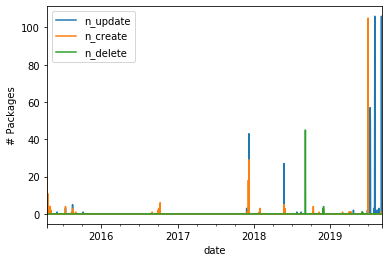

In [83]:
import matplotlib.pyplot as plt
dailyEDI.plot()
plt.ylabel('# Packages')

Text(0, 0.5, 'Cumulative Packages')

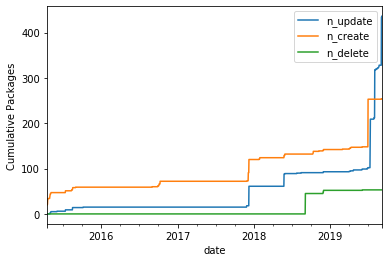

In [84]:
dailyEDI.cumsum().plot()
plt.ylabel('Cumulative Packages')

In [40]:
dailyEDI_nomet = df.loc[df.studyid!='437',['n_update', 'n_create']].resample('D').sum()
dailyEDI_nomet.head()

,n_update,n_create
date,,
2015-04-17,0,20
2015-04-18,0,1
2015-04-19,0,0
2015-04-20,0,11
2015-04-21,0,2


Text(0, 0.5, '# Packages')

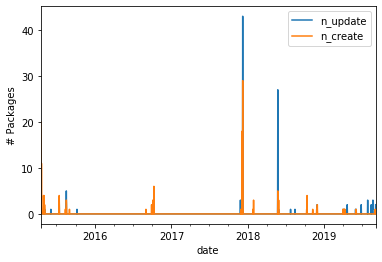

In [41]:
dailyEDI_nomet.plot()
plt.ylabel('# Packages')

Text(0, 0.5, 'Cumulative Packages')

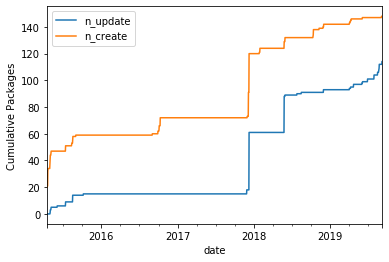

In [42]:
dailyEDI_nomet.cumsum().plot()
plt.ylabel('Cumulative Packages')